In [1]:
!pip install opencv-python

In [2]:
!pip install --ignore-installed --upgrade tensorflow

  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
  Using cached grpcio-1.44.0-cp38-cp38-win_amd64.whl (3.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.22.3-cp38-cp38-win_amd64.whl (14.7 MB)
  Using cached wrapt-1.14.0-cp38-cp38-win_amd64.whl (36 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-3.20.0-cp38-cp38-win_amd64.whl (904 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached setuptools-61.3.1-py3-none-any.whl (1.1 MB)
  Using cached libclang-13.0.0-py2.py3-none-win_amd64.whl (13.9 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

from tensorflow.keras.layers import Input, Dense, Add, Conv2D, LeakyReLU, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

plt.rcParams['figure.figsize'] = [15, 10]

In [6]:
IMG_WIDTH = 144
IMG_HEIGHT = 144
N_CLASSES = 9
dataset_path = "emojis/"
emojis = {
    0:{'class':'sad', 'image':'sad.png'},
    1:{'class':'cry', 'image':'cry.png'},
    2:{'class':'neutral', 'image':'neutral.png'},
    3:{'class':'surprise', 'image':'surprise.png'},
    4:{'class':'smile', 'image':'smile.png'},
    5:{'class':'kiss', 'image':'kiss.png'},
    6:{'class':'angry', 'image':'angry.png'},
    7:{'class':'angel', 'image':'angel.png'},
    8:{'class':'laugh', 'image':'laugh.png'},
}



In [7]:
# Read images into emojis dictionary
for i in range(len(emojis)):
    png_file = Image.open(dataset_path + emojis[i]["image"]).convert("RGBA")
    png_file.load()
    new_img = Image.new("RGB", png_file.size, (255,255,255))
    new_img.paste(png_file, mask=png_file.split()[3])
    emojis[i]["image"] = new_img

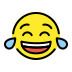

In [8]:
emojis[i]["image"]

In [9]:
# Function to draw bounding box on image

def plot_bbox(image, yt_box, yp_box=None, norm=False):
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, x2, y2 = yt_box
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    if yp_box is not None:
        x1, y1, x2, y2 = yp_box
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img

In [10]:
# Function to generate a new sample
# smaple: random sized emoji icon in a white-background image

def create_sample():
    # Random emoji class
    class_id = np.random.randint(0, 9)
    # Create white-background image
    image = np.ones((IMG_WIDTH, IMG_HEIGHT, 3)) * 255.
    # Get emoji image from emojis dictionary
    emoji_img = np.array(emojis[class_id]['image']).astype("uint8")
    
    # Randomly set icon's side size (width & height)
    size = np.random.randint(int(0.2*IMG_WIDTH), int(0.5*IMG_WIDTH))
    # Randomly set icon's position in image
    x = np.random.randint(0, size)
    y = np.random.randint(0, size)
    
    # Resize emoji icon to the specified size
    emoji_img = cv2.resize(emoji_img, (size, size))
    
    # Assign icon to its position in image
    image[y:y+size, x:x+size, :] = emoji_img[:,:,:3]
    
    # Set boundig-box values (+ tiny padding around icon)
    pad = 10/72 * size
    box = np.array((x+pad, y+pad, x-pad+size, y-pad+size))
    return image.astype("uint8"), box, class_id

[ 47.44444444  53.44444444  96.55555556 102.55555556]


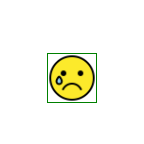

In [11]:
# Visualize one sample
img, box, cls_id = create_sample()
print(box)
plot_bbox(img, box)

In [12]:
# Function to generate samples (in batches)
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, IMG_WIDTH, IMG_HEIGHT, 3))
        y_batch = np.zeros((batch_size, 9))
        box_batch = np.zeros((batch_size, 4))
        for i in range(batch_size):
            image, box, class_id = create_sample()
            # Scale image
            x_batch[i] = image / 255.
            # Set the correct class as 1
            y_batch[i, class_id] = 1.0
            box_batch[i] = np.array([box])
        yield {"image":x_batch}, {"class_out":y_batch, "box_out":box_batch}

In [13]:
# Implementation of Intersection Over Union metric
class Iou(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(Iou, self).__init__(**kwargs)
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            y = y * IMG_WIDTH
            x1, y1, x2, y2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
            return x1, y1, x2, y2
        
        def get_area(points):
            x1, y1, x2, y2 = points
            return tf.math.abs(y2-y1) * tf.math.abs(x2-x1)
        
        yt_x1, yt_y1, yt_x2, yt_y2 = get_box(y_true)
        yp_x1, yp_y1, yp_x2, yp_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(yt_x1, yp_x1)
        i_y1 = tf.maximum(yt_y1, yp_y1)
        i_x2 = tf.minimum(yt_x2, yp_x2)
        i_y2 = tf.minimum(yt_y2, yp_y2)
        
        i_area = get_area((i_x1, i_y1, i_x2, i_y2))
        total_area = get_area(get_box(y_true)) + get_area(get_box(y_pred)) - i_area
        
        iou = tf.math.divide(i_area, total_area)
        
        self.num_ex.assign(1)
        self.total_iou.assign(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

In [14]:
# A function to test the model on random samples during training
def test(model, sample=None):
    if sample is None:
        sample = next(data_generator())
    # Retrieve sample details
    inp, out = sample
    image = inp["image"]
    yt_box = out["box_out"]
    yt_class = np.argmax(out["class_out"], axis=1)
    # Predict sample & Retrieve output
    class_out, yp_box = model.predict(image)
    yp_class_ids = tf.math.argmax(class_out, axis=1)
    
    fig, ax = plt.subplots(1, 6)
    for i in range(min(len(image), 6)):
        yp_class_name = emojis[yp_class_ids[i].numpy()]["class"]
        yt_class_name = emojis[yt_class[i]]["class"]
        image_plotted = plot_bbox(image[i], yt_box[i], yp_box[i], norm=True) # continue

        ax[i].imshow(image_plotted)
        ax[i].set_axis_off()
        ax[i].set_title(f"{yt_class_name} | {yp_class_name}")
    plt.show()

In [15]:
# Callback to predict random samples after each epoch
class ShowTest(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.01
    return max(lr, 5e-5)

In [16]:
# CNN Architecture

inp = Input(shape=(IMG_WIDTH, IMG_HEIGHT,3), name='image')
x = inp
for i in range(5):
    n_filters = 2 ** (4+i)
    x = Conv2D(n_filters, (3,3), padding='same')(x)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(n_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(n_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(4, name='box_out')(x)

model = Model(inp, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 144, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 144, 144, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

 add_2 (Add)                    (None, 36, 36, 64)   0           ['batch_normalization_8[0][0]',  
                                                                  'conv2d_6[0][0]']               
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 36, 36, 64)   0           ['add_2[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 18, 18, 64)  0           ['leaky_re_lu_8[0][0]']          
                                                                                                  
 conv2d_9 (Conv2D)              (None, 18, 18, 128)  73856       ['max_pooling2d_2[0][0]']        
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 18, 18, 128)  512        ['conv2d_9[0][0]']               
 rmalizati

# CNN Architecture
![](https://lh5.googleusercontent.com/jM21yNYHPqMaSUglR_jRuTr3xLaauuFOnIlManAl14ovogB9LjV8su2WU3CZQdx7XGR1Axp3EFjb54YJfUS4=w1366-h657-rw)

In [17]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(
    loss={
        "class_out":"categorical_crossentropy",
        "box_out":"mse"
    },
    metrics={
        "class_out":"accuracy",
        "box_out":Iou(name="iou")
    },
    optimizer=adam
)

Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 57.4127 - class_out_loss: 4.2480 - box_out_loss: 53.1647 - class_out_accuracy: 0.1094 - box_out_iou: 0.9124

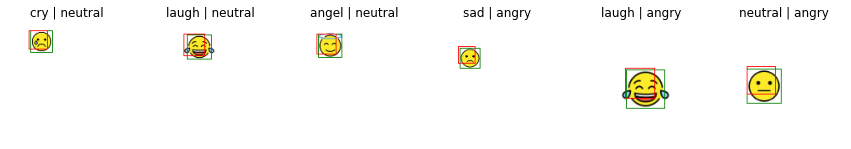

500/500 [==============================] - 575s 1s/step - loss: 57.4127 - class_out_loss: 4.2480 - box_out_loss: 53.1647 - class_out_accuracy: 0.1094 - box_out_iou: 0.9124 - lr: 0.0030
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 6.0997 - class_out_loss: 3.0364 - box_out_loss: 3.0633 - class_out_accuracy: 0.1198 - box_out_iou: 0.8648

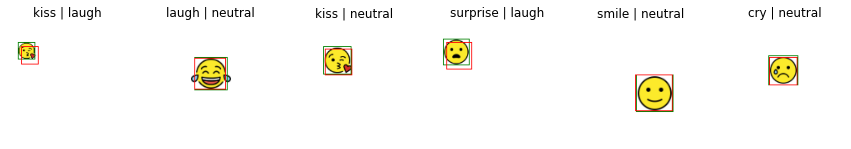

500/500 [==============================] - 569s 1s/step - loss: 6.0997 - class_out_loss: 3.0364 - box_out_loss: 3.0633 - class_out_accuracy: 0.1198 - box_out_iou: 0.8648 - lr: 0.0030
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 5.0937 - class_out_loss: 2.7058 - box_out_loss: 2.3879 - class_out_accuracy: 0.1902 - box_out_iou: 0.8752

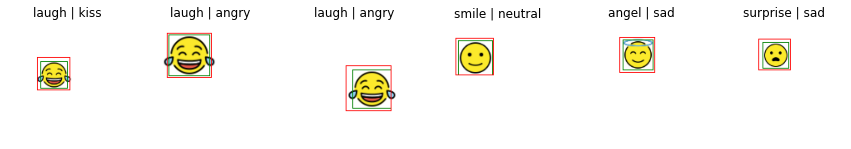

500/500 [==============================] - 572s 1s/step - loss: 5.0937 - class_out_loss: 2.7058 - box_out_loss: 2.3879 - class_out_accuracy: 0.1902 - box_out_iou: 0.8752 - lr: 0.0030
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 5.4016 - class_out_loss: 1.7169 - box_out_loss: 3.6847 - class_out_accuracy: 0.4187 - box_out_iou: 0.8939

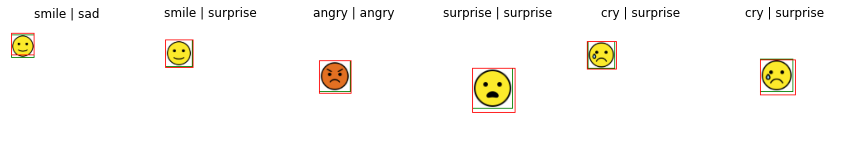

500/500 [==============================] - 566s 1s/step - loss: 5.4016 - class_out_loss: 1.7169 - box_out_loss: 3.6847 - class_out_accuracy: 0.4187 - box_out_iou: 0.8939 - lr: 0.0030
Epoch 5/50
500/500 [==============================] - ETA: 0s - loss: 1.5397 - class_out_loss: 0.8871 - box_out_loss: 0.6526 - class_out_accuracy: 0.6507 - box_out_iou: 0.9317

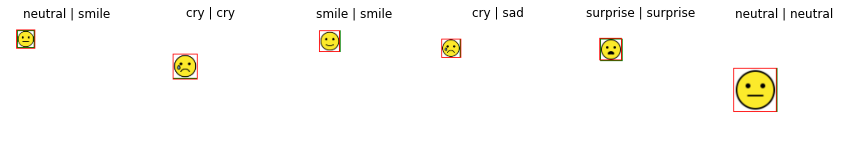

500/500 [==============================] - 585s 1s/step - loss: 1.5397 - class_out_loss: 0.8871 - box_out_loss: 0.6526 - class_out_accuracy: 0.6507 - box_out_iou: 0.9317 - lr: 5.0000e-05
Epoch 6/50
500/500 [==============================] - ETA: 0s - loss: 1.2177 - class_out_loss: 0.8260 - box_out_loss: 0.3917 - class_out_accuracy: 0.6664 - box_out_iou: 0.9485

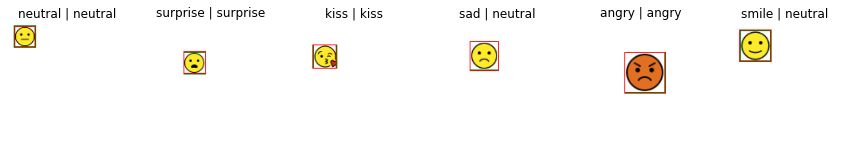

500/500 [==============================] - 581s 1s/step - loss: 1.2177 - class_out_loss: 0.8260 - box_out_loss: 0.3917 - class_out_accuracy: 0.6664 - box_out_iou: 0.9485 - lr: 5.0000e-05
Epoch 7/50
500/500 [==============================] - ETA: 0s - loss: 1.1243 - class_out_loss: 0.7926 - box_out_loss: 0.3317 - class_out_accuracy: 0.6819 - box_out_iou: 0.9678

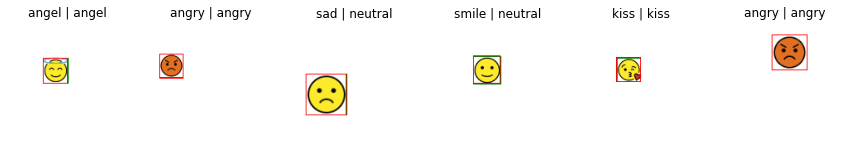

500/500 [==============================] - 532s 1s/step - loss: 1.1243 - class_out_loss: 0.7926 - box_out_loss: 0.3317 - class_out_accuracy: 0.6819 - box_out_iou: 0.9678 - lr: 5.0000e-05
Epoch 8/50
500/500 [==============================] - ETA: 0s - loss: 1.0226 - class_out_loss: 0.7498 - box_out_loss: 0.2728 - class_out_accuracy: 0.6991 - box_out_iou: 0.9588

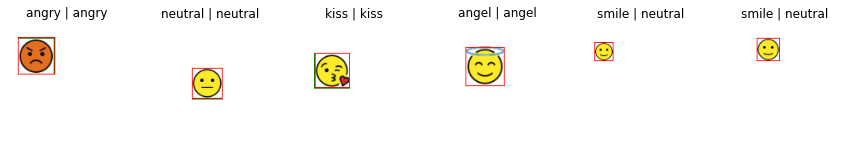

500/500 [==============================] - 458s 916ms/step - loss: 1.0226 - class_out_loss: 0.7498 - box_out_loss: 0.2728 - class_out_accuracy: 0.6991 - box_out_iou: 0.9588 - lr: 5.0000e-05
Epoch 9/50
500/500 [==============================] - ETA: 0s - loss: 0.9665 - class_out_loss: 0.7106 - box_out_loss: 0.2559 - class_out_accuracy: 0.7124 - box_out_iou: 0.9589

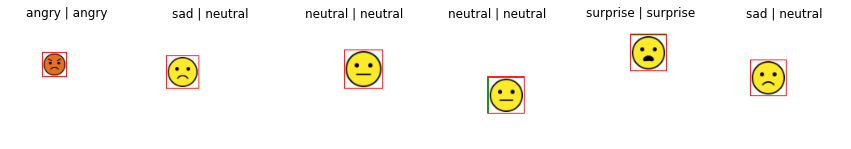

500/500 [==============================] - 421s 842ms/step - loss: 0.9665 - class_out_loss: 0.7106 - box_out_loss: 0.2559 - class_out_accuracy: 0.7124 - box_out_iou: 0.9589 - lr: 5.0000e-05
Epoch 10/50
500/500 [==============================] - ETA: 0s - loss: 0.9333 - class_out_loss: 0.6837 - box_out_loss: 0.2496 - class_out_accuracy: 0.7145 - box_out_iou: 0.9546

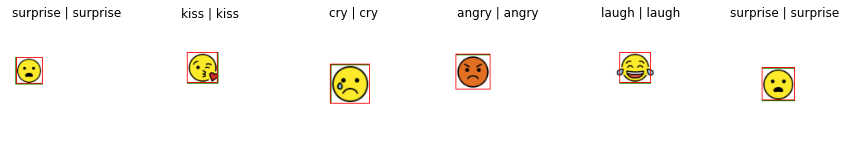

500/500 [==============================] - 415s 831ms/step - loss: 0.9333 - class_out_loss: 0.6837 - box_out_loss: 0.2496 - class_out_accuracy: 0.7145 - box_out_iou: 0.9546 - lr: 5.0000e-05
Epoch 11/50
500/500 [==============================] - ETA: 0s - loss: 0.8812 - class_out_loss: 0.6521 - box_out_loss: 0.2291 - class_out_accuracy: 0.7315 - box_out_iou: 0.9569

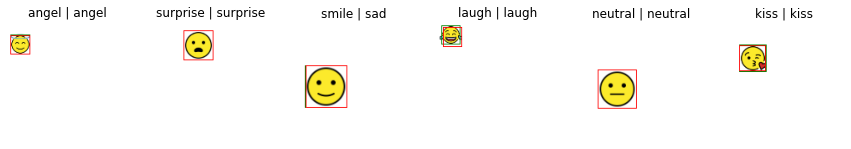

500/500 [==============================] - 405s 810ms/step - loss: 0.8812 - class_out_loss: 0.6521 - box_out_loss: 0.2291 - class_out_accuracy: 0.7315 - box_out_iou: 0.9569 - lr: 5.0000e-05
Epoch 12/50
500/500 [==============================] - ETA: 0s - loss: 0.8530 - class_out_loss: 0.6364 - box_out_loss: 0.2166 - class_out_accuracy: 0.7412 - box_out_iou: 0.9614

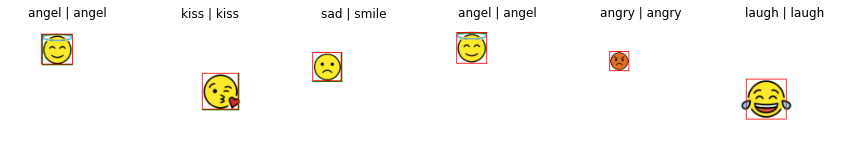

500/500 [==============================] - 490s 980ms/step - loss: 0.8530 - class_out_loss: 0.6364 - box_out_loss: 0.2166 - class_out_accuracy: 0.7412 - box_out_iou: 0.9614 - lr: 5.0000e-05
Epoch 13/50
500/500 [==============================] - ETA: 0s - loss: 0.8120 - class_out_loss: 0.6077 - box_out_loss: 0.2043 - class_out_accuracy: 0.7458 - box_out_iou: 0.9652

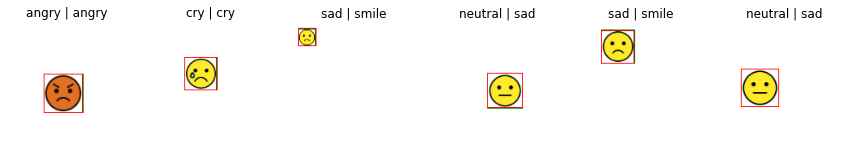

500/500 [==============================] - 497s 994ms/step - loss: 0.8120 - class_out_loss: 0.6077 - box_out_loss: 0.2043 - class_out_accuracy: 0.7458 - box_out_iou: 0.9652 - lr: 5.0000e-05
Epoch 14/50
500/500 [==============================] - ETA: 0s - loss: 0.7523 - class_out_loss: 0.5668 - box_out_loss: 0.1855 - class_out_accuracy: 0.7697 - box_out_iou: 0.9647

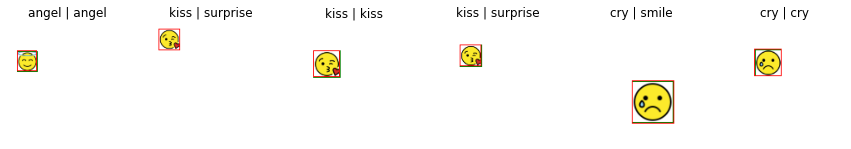

500/500 [==============================] - 494s 989ms/step - loss: 0.7523 - class_out_loss: 0.5668 - box_out_loss: 0.1855 - class_out_accuracy: 0.7697 - box_out_iou: 0.9647 - lr: 5.0000e-05
Epoch 15/50
500/500 [==============================] - ETA: 0s - loss: 0.6962 - class_out_loss: 0.5070 - box_out_loss: 0.1892 - class_out_accuracy: 0.7921 - box_out_iou: 0.9581

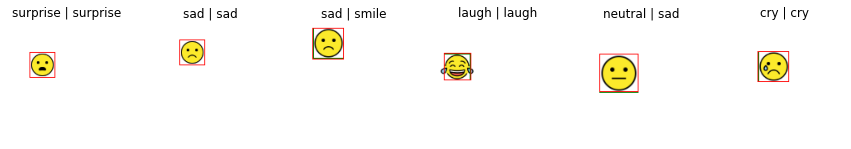

500/500 [==============================] - 460s 920ms/step - loss: 0.6962 - class_out_loss: 0.5070 - box_out_loss: 0.1892 - class_out_accuracy: 0.7921 - box_out_iou: 0.9581 - lr: 5.0000e-05
Epoch 16/50
500/500 [==============================] - ETA: 0s - loss: 0.6682 - class_out_loss: 0.4829 - box_out_loss: 0.1853 - class_out_accuracy: 0.7937 - box_out_iou: 0.9649

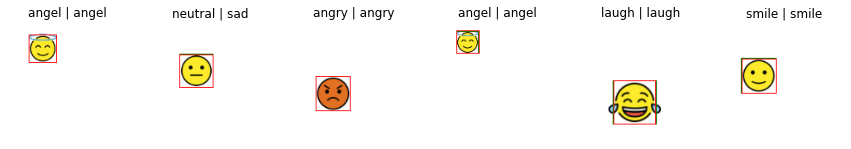

500/500 [==============================] - 454s 908ms/step - loss: 0.6682 - class_out_loss: 0.4829 - box_out_loss: 0.1853 - class_out_accuracy: 0.7937 - box_out_iou: 0.9649 - lr: 5.0000e-05
Epoch 17/50
500/500 [==============================] - ETA: 0s - loss: 0.6177 - class_out_loss: 0.4407 - box_out_loss: 0.1770 - class_out_accuracy: 0.8190 - box_out_iou: 0.9648

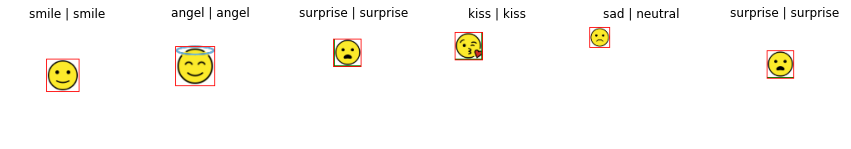

500/500 [==============================] - 486s 973ms/step - loss: 0.6177 - class_out_loss: 0.4407 - box_out_loss: 0.1770 - class_out_accuracy: 0.8190 - box_out_iou: 0.9648 - lr: 5.0000e-05
Epoch 18/50
500/500 [==============================] - ETA: 0s - loss: 0.5825 - class_out_loss: 0.4049 - box_out_loss: 0.1777 - class_out_accuracy: 0.8295 - box_out_iou: 0.9737

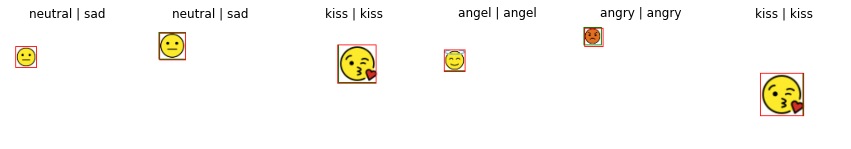

500/500 [==============================] - 487s 973ms/step - loss: 0.5825 - class_out_loss: 0.4049 - box_out_loss: 0.1777 - class_out_accuracy: 0.8295 - box_out_iou: 0.9737 - lr: 5.0000e-05
Epoch 19/50
500/500 [==============================] - ETA: 0s - loss: 0.5150 - class_out_loss: 0.3536 - box_out_loss: 0.1615 - class_out_accuracy: 0.8546 - box_out_iou: 0.9748

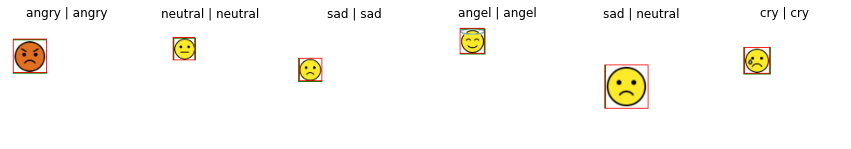

500/500 [==============================] - 489s 979ms/step - loss: 0.5150 - class_out_loss: 0.3536 - box_out_loss: 0.1615 - class_out_accuracy: 0.8546 - box_out_iou: 0.9748 - lr: 5.0000e-05
Epoch 20/50
500/500 [==============================] - ETA: 0s - loss: 0.4737 - class_out_loss: 0.3159 - box_out_loss: 0.1578 - class_out_accuracy: 0.8765 - box_out_iou: 0.9775

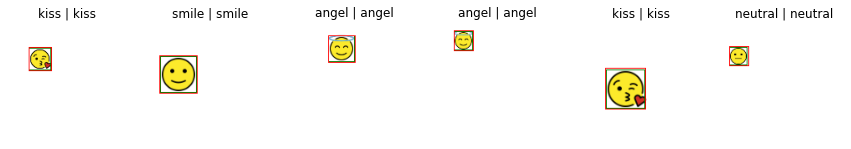

500/500 [==============================] - 418s 837ms/step - loss: 0.4737 - class_out_loss: 0.3159 - box_out_loss: 0.1578 - class_out_accuracy: 0.8765 - box_out_iou: 0.9775 - lr: 5.0000e-05
Epoch 21/50
500/500 [==============================] - ETA: 0s - loss: 0.4372 - class_out_loss: 0.2917 - box_out_loss: 0.1455 - class_out_accuracy: 0.8810 - box_out_iou: 0.9697

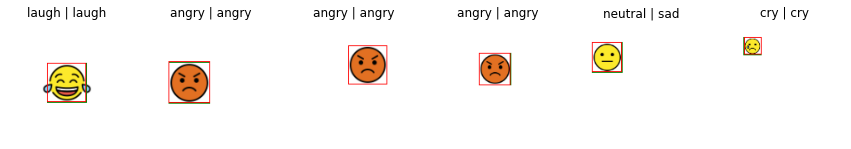

500/500 [==============================] - 419s 837ms/step - loss: 0.4372 - class_out_loss: 0.2917 - box_out_loss: 0.1455 - class_out_accuracy: 0.8810 - box_out_iou: 0.9697 - lr: 5.0000e-05
Epoch 22/50
500/500 [==============================] - ETA: 0s - loss: 0.3829 - class_out_loss: 0.2407 - box_out_loss: 0.1422 - class_out_accuracy: 0.9120 - box_out_iou: 0.9633

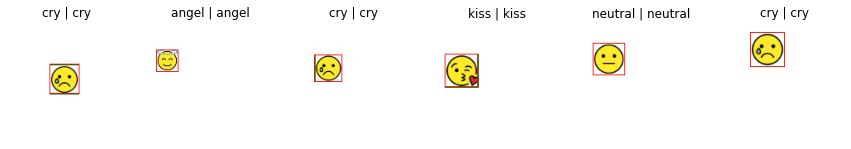

500/500 [==============================] - 418s 835ms/step - loss: 0.3829 - class_out_loss: 0.2407 - box_out_loss: 0.1422 - class_out_accuracy: 0.9120 - box_out_iou: 0.9633 - lr: 5.0000e-05
Epoch 23/50
500/500 [==============================] - ETA: 0s - loss: 0.3548 - class_out_loss: 0.2108 - box_out_loss: 0.1441 - class_out_accuracy: 0.9244 - box_out_iou: 0.9738

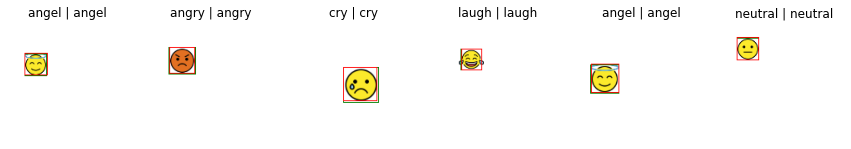

500/500 [==============================] - 420s 841ms/step - loss: 0.3548 - class_out_loss: 0.2108 - box_out_loss: 0.1441 - class_out_accuracy: 0.9244 - box_out_iou: 0.9738 - lr: 5.0000e-05
Epoch 24/50
500/500 [==============================] - ETA: 0s - loss: 0.3328 - class_out_loss: 0.1816 - box_out_loss: 0.1511 - class_out_accuracy: 0.9395 - box_out_iou: 0.9516

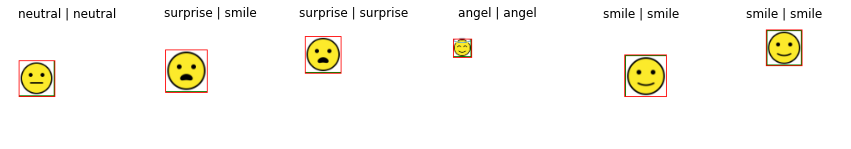

500/500 [==============================] - 422s 844ms/step - loss: 0.3328 - class_out_loss: 0.1816 - box_out_loss: 0.1511 - class_out_accuracy: 0.9395 - box_out_iou: 0.9516 - lr: 5.0000e-05
Epoch 25/50
500/500 [==============================] - ETA: 0s - loss: 0.2968 - class_out_loss: 0.1585 - box_out_loss: 0.1383 - class_out_accuracy: 0.9476 - box_out_iou: 0.9740

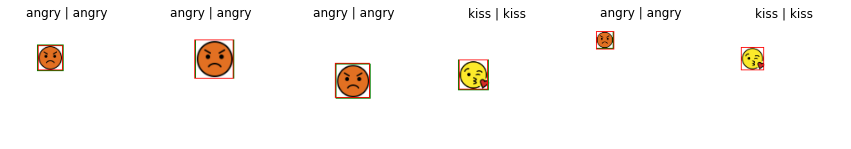

500/500 [==============================] - 426s 853ms/step - loss: 0.2968 - class_out_loss: 0.1585 - box_out_loss: 0.1383 - class_out_accuracy: 0.9476 - box_out_iou: 0.9740 - lr: 5.0000e-05
Epoch 26/50
500/500 [==============================] - ETA: 0s - loss: 0.2679 - class_out_loss: 0.1223 - box_out_loss: 0.1456 - class_out_accuracy: 0.9679 - box_out_iou: 0.9612

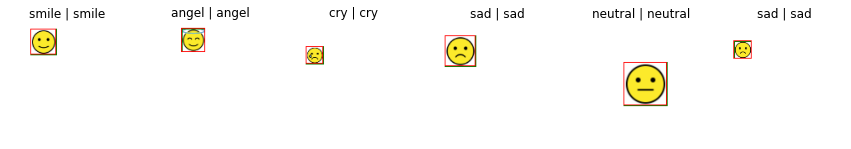

500/500 [==============================] - 425s 850ms/step - loss: 0.2679 - class_out_loss: 0.1223 - box_out_loss: 0.1456 - class_out_accuracy: 0.9679 - box_out_iou: 0.9612 - lr: 5.0000e-05
Epoch 27/50
500/500 [==============================] - ETA: 0s - loss: 0.2528 - class_out_loss: 0.1200 - box_out_loss: 0.1328 - class_out_accuracy: 0.9649 - box_out_iou: 0.9824

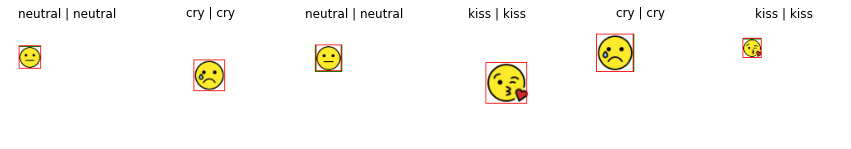

500/500 [==============================] - 426s 853ms/step - loss: 0.2528 - class_out_loss: 0.1200 - box_out_loss: 0.1328 - class_out_accuracy: 0.9649 - box_out_iou: 0.9824 - lr: 5.0000e-05
Epoch 28/50
500/500 [==============================] - ETA: 0s - loss: 0.2179 - class_out_loss: 0.0929 - box_out_loss: 0.1249 - class_out_accuracy: 0.9758 - box_out_iou: 0.9786

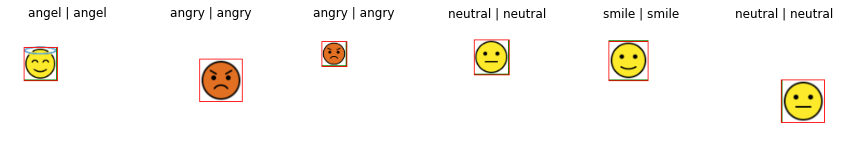

500/500 [==============================] - 464s 929ms/step - loss: 0.2179 - class_out_loss: 0.0929 - box_out_loss: 0.1249 - class_out_accuracy: 0.9758 - box_out_iou: 0.9786 - lr: 5.0000e-05
Epoch 29/50
500/500 [==============================] - ETA: 0s - loss: 0.1900 - class_out_loss: 0.0746 - box_out_loss: 0.1154 - class_out_accuracy: 0.9830 - box_out_iou: 0.9743

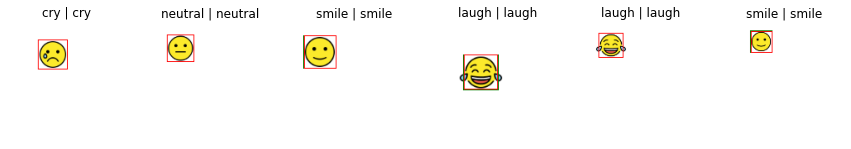

500/500 [==============================] - 576s 1s/step - loss: 0.1900 - class_out_loss: 0.0746 - box_out_loss: 0.1154 - class_out_accuracy: 0.9830 - box_out_iou: 0.9743 - lr: 5.0000e-05
Epoch 30/50
500/500 [==============================] - ETA: 0s - loss: 0.1768 - class_out_loss: 0.0671 - box_out_loss: 0.1097 - class_out_accuracy: 0.9852 - box_out_iou: 0.9756

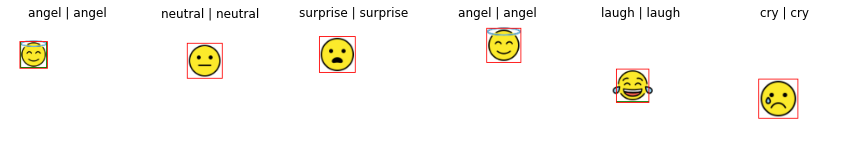

500/500 [==============================] - 576s 1s/step - loss: 0.1768 - class_out_loss: 0.0671 - box_out_loss: 0.1097 - class_out_accuracy: 0.9852 - box_out_iou: 0.9756 - lr: 5.0000e-05
Epoch 31/50
500/500 [==============================] - ETA: 0s - loss: 0.1513 - class_out_loss: 0.0519 - box_out_loss: 0.0994 - class_out_accuracy: 0.9906 - box_out_iou: 0.9773

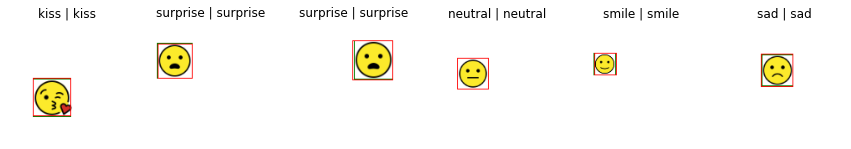

500/500 [==============================] - 576s 1s/step - loss: 0.1513 - class_out_loss: 0.0519 - box_out_loss: 0.0994 - class_out_accuracy: 0.9906 - box_out_iou: 0.9773 - lr: 5.0000e-05
Epoch 32/50
500/500 [==============================] - ETA: 0s - loss: 0.1507 - class_out_loss: 0.0472 - box_out_loss: 0.1035 - class_out_accuracy: 0.9919 - box_out_iou: 0.9742

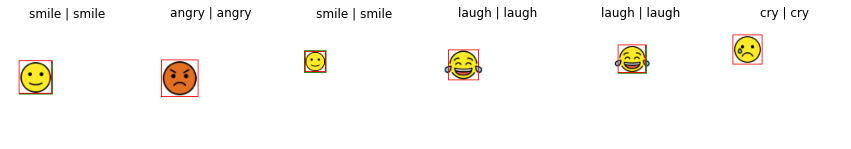

500/500 [==============================] - 570s 1s/step - loss: 0.1507 - class_out_loss: 0.0472 - box_out_loss: 0.1035 - class_out_accuracy: 0.9919 - box_out_iou: 0.9742 - lr: 5.0000e-05
Epoch 33/50
500/500 [==============================] - ETA: 0s - loss: 0.1340 - class_out_loss: 0.0427 - box_out_loss: 0.0913 - class_out_accuracy: 0.9927 - box_out_iou: 0.9726

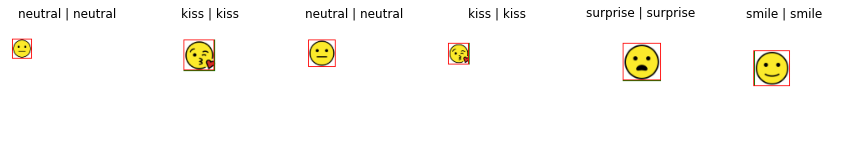

500/500 [==============================] - 566s 1s/step - loss: 0.1340 - class_out_loss: 0.0427 - box_out_loss: 0.0913 - class_out_accuracy: 0.9927 - box_out_iou: 0.9726 - lr: 5.0000e-05
Epoch 34/50
500/500 [==============================] - ETA: 0s - loss: 0.1342 - class_out_loss: 0.0389 - box_out_loss: 0.0953 - class_out_accuracy: 0.9931 - box_out_iou: 0.9738

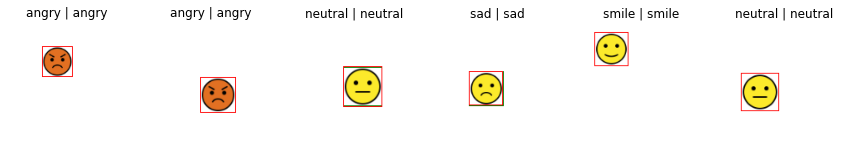

500/500 [==============================] - 577s 1s/step - loss: 0.1342 - class_out_loss: 0.0389 - box_out_loss: 0.0953 - class_out_accuracy: 0.9931 - box_out_iou: 0.9738 - lr: 5.0000e-05
Epoch 35/50
500/500 [==============================] - ETA: 0s - loss: 0.1489 - class_out_loss: 0.0432 - box_out_loss: 0.1057 - class_out_accuracy: 0.9895 - box_out_iou: 0.9746

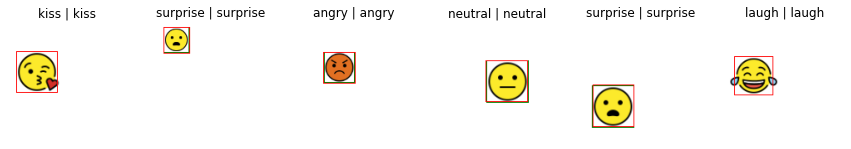

500/500 [==============================] - 581s 1s/step - loss: 0.1489 - class_out_loss: 0.0432 - box_out_loss: 0.1057 - class_out_accuracy: 0.9895 - box_out_iou: 0.9746 - lr: 5.0000e-05
Epoch 36/50
500/500 [==============================] - ETA: 0s - loss: 0.1202 - class_out_loss: 0.0272 - box_out_loss: 0.0929 - class_out_accuracy: 0.9966 - box_out_iou: 0.9710

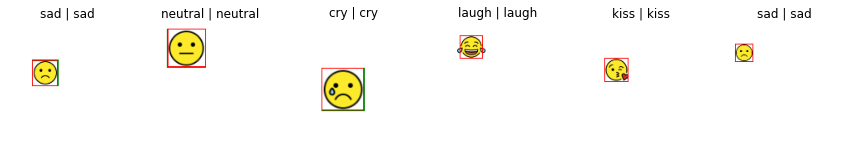

500/500 [==============================] - 574s 1s/step - loss: 0.1202 - class_out_loss: 0.0272 - box_out_loss: 0.0929 - class_out_accuracy: 0.9966 - box_out_iou: 0.9710 - lr: 5.0000e-05
Epoch 37/50
500/500 [==============================] - ETA: 0s - loss: 0.1117 - class_out_loss: 0.0249 - box_out_loss: 0.0868 - class_out_accuracy: 0.9967 - box_out_iou: 0.9767

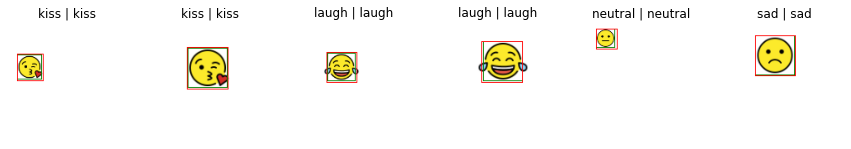

500/500 [==============================] - 580s 1s/step - loss: 0.1117 - class_out_loss: 0.0249 - box_out_loss: 0.0868 - class_out_accuracy: 0.9967 - box_out_iou: 0.9767 - lr: 5.0000e-05
Epoch 38/50
500/500 [==============================] - ETA: 0s - loss: 0.1115 - class_out_loss: 0.0252 - box_out_loss: 0.0863 - class_out_accuracy: 0.9960 - box_out_iou: 0.9752

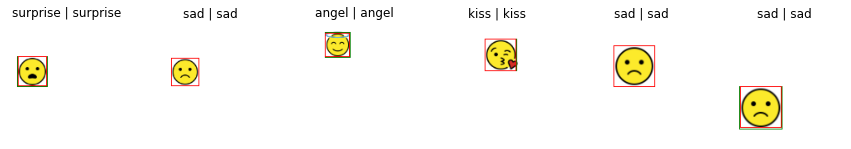

500/500 [==============================] - 576s 1s/step - loss: 0.1115 - class_out_loss: 0.0252 - box_out_loss: 0.0863 - class_out_accuracy: 0.9960 - box_out_iou: 0.9752 - lr: 5.0000e-05
Epoch 39/50
500/500 [==============================] - ETA: 0s - loss: 0.0971 - class_out_loss: 0.0193 - box_out_loss: 0.0778 - class_out_accuracy: 0.9983 - box_out_iou: 0.9833

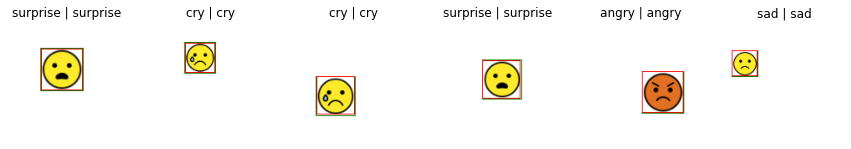

500/500 [==============================] - 572s 1s/step - loss: 0.0971 - class_out_loss: 0.0193 - box_out_loss: 0.0778 - class_out_accuracy: 0.9983 - box_out_iou: 0.9833 - lr: 5.0000e-05
Epoch 40/50
500/500 [==============================] - ETA: 0s - loss: 0.1008 - class_out_loss: 0.0201 - box_out_loss: 0.0807 - class_out_accuracy: 0.9973 - box_out_iou: 0.9695

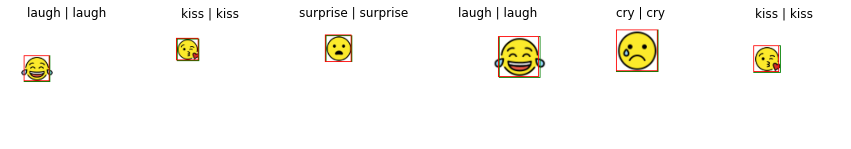

500/500 [==============================] - 559s 1s/step - loss: 0.1008 - class_out_loss: 0.0201 - box_out_loss: 0.0807 - class_out_accuracy: 0.9973 - box_out_iou: 0.9695 - lr: 5.0000e-05
Epoch 41/50
500/500 [==============================] - ETA: 0s - loss: 0.1030 - class_out_loss: 0.0198 - box_out_loss: 0.0832 - class_out_accuracy: 0.9967 - box_out_iou: 0.9788

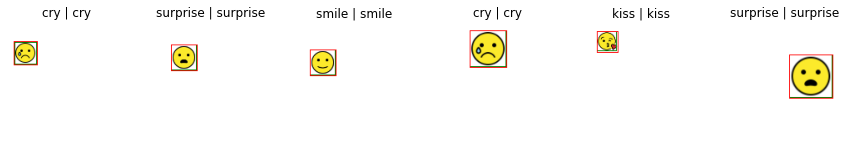

500/500 [==============================] - 581s 1s/step - loss: 0.1030 - class_out_loss: 0.0198 - box_out_loss: 0.0832 - class_out_accuracy: 0.9967 - box_out_iou: 0.9788 - lr: 5.0000e-05
Epoch 42/50
500/500 [==============================] - ETA: 0s - loss: 0.0936 - class_out_loss: 0.0168 - box_out_loss: 0.0768 - class_out_accuracy: 0.9976 - box_out_iou: 0.9792

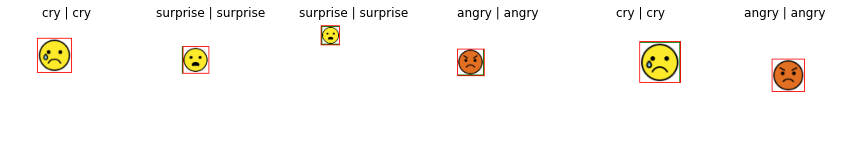

500/500 [==============================] - 579s 1s/step - loss: 0.0936 - class_out_loss: 0.0168 - box_out_loss: 0.0768 - class_out_accuracy: 0.9976 - box_out_iou: 0.9792 - lr: 5.0000e-05
Epoch 43/50
500/500 [==============================] - ETA: 0s - loss: 0.0809 - class_out_loss: 0.0119 - box_out_loss: 0.0690 - class_out_accuracy: 0.9994 - box_out_iou: 0.9731

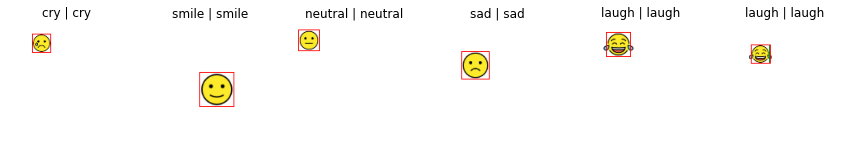

500/500 [==============================] - 573s 1s/step - loss: 0.0809 - class_out_loss: 0.0119 - box_out_loss: 0.0690 - class_out_accuracy: 0.9994 - box_out_iou: 0.9731 - lr: 5.0000e-05
Epoch 44/50
500/500 [==============================] - ETA: 0s - loss: 0.0767 - class_out_loss: 0.0128 - box_out_loss: 0.0639 - class_out_accuracy: 0.9983 - box_out_iou: 0.9793

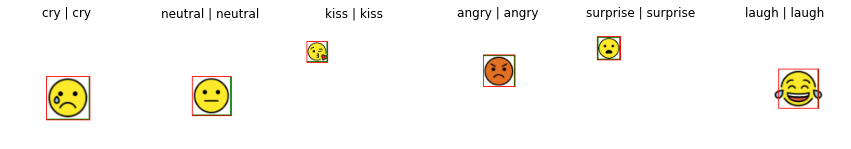

500/500 [==============================] - 585s 1s/step - loss: 0.0767 - class_out_loss: 0.0128 - box_out_loss: 0.0639 - class_out_accuracy: 0.9983 - box_out_iou: 0.9793 - lr: 5.0000e-05
Epoch 45/50
500/500 [==============================] - ETA: 0s - loss: 0.0949 - class_out_loss: 0.0125 - box_out_loss: 0.0824 - class_out_accuracy: 0.9990 - box_out_iou: 0.9753

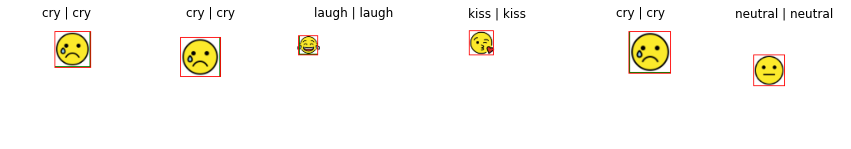

500/500 [==============================] - 421s 843ms/step - loss: 0.0949 - class_out_loss: 0.0125 - box_out_loss: 0.0824 - class_out_accuracy: 0.9990 - box_out_iou: 0.9753 - lr: 5.0000e-05
Epoch 46/50
500/500 [==============================] - ETA: 0s - loss: 0.0849 - class_out_loss: 0.0091 - box_out_loss: 0.0758 - class_out_accuracy: 0.9994 - box_out_iou: 0.9808

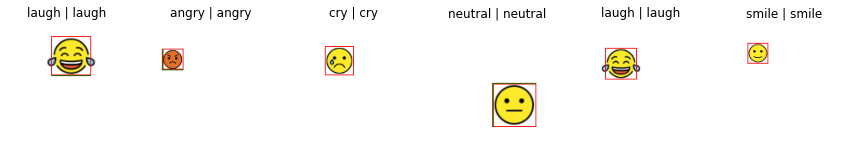

500/500 [==============================] - 373s 746ms/step - loss: 0.0849 - class_out_loss: 0.0091 - box_out_loss: 0.0758 - class_out_accuracy: 0.9994 - box_out_iou: 0.9808 - lr: 5.0000e-05
Epoch 47/50
500/500 [==============================] - ETA: 0s - loss: 0.0724 - class_out_loss: 0.0092 - box_out_loss: 0.0632 - class_out_accuracy: 0.9994 - box_out_iou: 0.9810

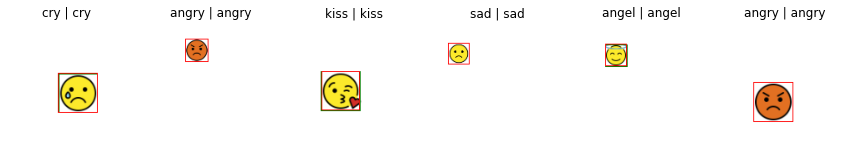

500/500 [==============================] - 374s 748ms/step - loss: 0.0724 - class_out_loss: 0.0092 - box_out_loss: 0.0632 - class_out_accuracy: 0.9994 - box_out_iou: 0.9810 - lr: 5.0000e-05
Epoch 48/50
500/500 [==============================] - ETA: 0s - loss: 0.0865 - class_out_loss: 0.0152 - box_out_loss: 0.0713 - class_out_accuracy: 0.9966 - box_out_iou: 0.9797

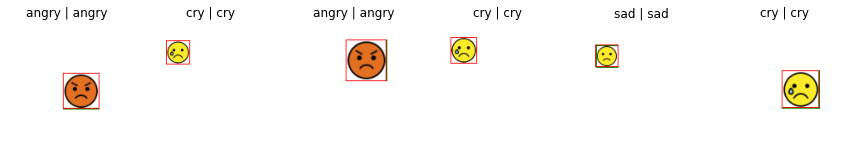

500/500 [==============================] - 409s 818ms/step - loss: 0.0865 - class_out_loss: 0.0152 - box_out_loss: 0.0713 - class_out_accuracy: 0.9966 - box_out_iou: 0.9797 - lr: 5.0000e-05
Epoch 49/50
500/500 [==============================] - ETA: 0s - loss: 0.0642 - class_out_loss: 0.0074 - box_out_loss: 0.0568 - class_out_accuracy: 0.9995 - box_out_iou: 0.9834

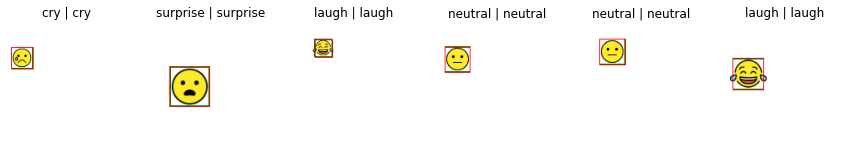

500/500 [==============================] - 439s 878ms/step - loss: 0.0642 - class_out_loss: 0.0074 - box_out_loss: 0.0568 - class_out_accuracy: 0.9995 - box_out_iou: 0.9834 - lr: 5.0000e-05
Epoch 50/50
500/500 [==============================] - ETA: 0s - loss: 0.0643 - class_out_loss: 0.0070 - box_out_loss: 0.0573 - class_out_accuracy: 0.9996 - box_out_iou: 0.9787

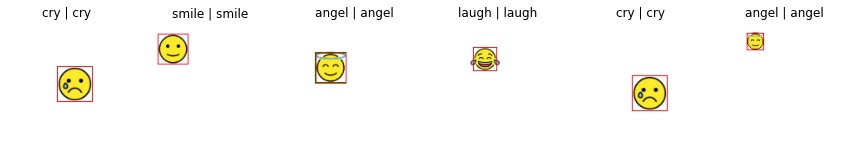

500/500 [==============================] - 447s 894ms/step - loss: 0.0643 - class_out_loss: 0.0070 - box_out_loss: 0.0573 - class_out_accuracy: 0.9996 - box_out_iou: 0.9787 - lr: 5.0000e-05


In [18]:
history = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTest(),
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    ]
)

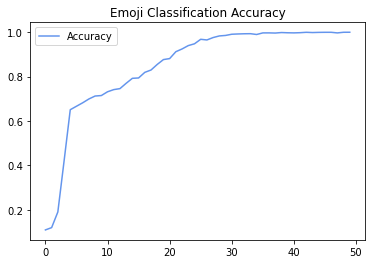

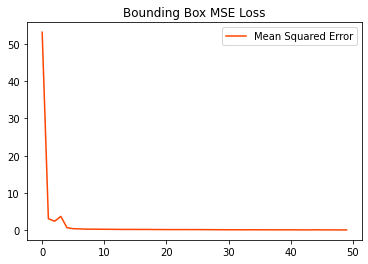

In [19]:
# Visualize Loss & Accuracy

%matplotlib inline
acc = history.history['class_out_accuracy']
loss = history.history['box_out_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'cornflowerblue', label='Accuracy')
plt.title('Emoji Classification Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'orangered', label='Mean Squared Error')
plt.title('Bounding Box MSE Loss')
plt.legend()

plt.show()